# Training neural network with 2 hidden layer
### Import packages and get the data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import style
import util
import get_data, sklearn
import datetime as dt
%matplotlib inline

style.use('ggplot')

# Choose start/end date
start_date = '1950-1-3'
end_date = '2017-4-21'
dates = pd.date_range(start_date, end_date)

# Choose which stock to look at
stock = '^GSPC'

data = get_data.get_data_csv(stock, dates, redownload=False)
data.dropna(inplace=True)
data = util.remove_data_with_same_open_close(data)
data.head()

,Open,High,Low,Close,Volume,Adj Close
1962-01-02,71.550003,71.959999,70.709999,70.959999,3120000.0,70.959999
1962-01-03,70.959999,71.480003,70.379997,71.129997,3590000.0,71.129997
1962-01-04,71.129997,71.620003,70.449997,70.639999,4450000.0,70.639999
1962-01-05,70.639999,70.839996,69.349998,69.660004,4630000.0,69.660004
1962-01-08,69.660004,69.839996,68.169998,69.120003,4620000.0,69.120003


### Data Preprocessing

In [2]:
# calculate features
datanew = util.calc_features_new(data, look_back=120, fee=0)
datanew.dropna(inplace=True)
target = datanew['Change']
features = datanew.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Change'], axis=1)
from sklearn import preprocessing
features_scaled = pd.DataFrame(preprocessing.scale(features))

In [3]:
#Train-test data splits for roll-forward cross validation
from sklearn.model_selection import TimeSeriesSplit
n_splits = 15
tscv = TimeSeriesSplit(n_splits=n_splits)

In [4]:
#prepare the target data with one-hot encoding
target = pd.DataFrame(target)
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder()
one_hot.fit(target)
target_scaled = one_hot.transform(target).toarray()

In [5]:
from NeuralNetwork_Cross_Entropy_mini_batch import NeuralNetwork
import tensorflow as tf
# function that train neural networks with 2 hidden layer
def neuralnetwork_2hiddenlayer(sess, h, learning_rate = 0.001, training_epochs=10000, keep_prob=1.0):
    # - input
    #  sess: the tensorflow session
    #  h: the number of neurons in the hidden layers. 
    #    h[0]: the number of neurons in the first layer
    #    h[1]: the number of neurons in the second layer
    #  learning_rate: learning rate 
    #  training_epochs: total number of training iteration
    #  keep_prob: keep probability of drop-out
    #
    # - output
    #  nnmodel: neural network model instance
    #  y_pred: the predicted probability for stock market increase/decrease for the last split
    #  y_test: the test data for the last split
    #  test_index: the index for the testing data in the last split
    #  accuracy_list: the accuracy for the splits
    #  cost_list: the cost or loss for training splits
    #  test_cost_list: the cost or loss for testing splits
    
    i = 1
    accuracy_list = []
    test_cost_list = []
    cost_list = []
    for train_index, test_index in tscv.split(features_scaled):
        i += 1
        X_train, X_test = features_scaled.values[train_index], features_scaled.values[test_index]
        y_train, y_test = target_scaled[train_index], target_scaled[test_index]
        
        nnmodel = NeuralNetwork(sess, X_train.shape[0], X_train.shape[1], n_nodes=h,\
                                actf=[tf.nn.relu, tf.nn.sigmoid], dropout = [True, False],\
                                learning_rate=learning_rate, training_epochs=training_epochs)
        # train and test
        y_pred, cost, test_cost = nnmodel.train_and_test(X_train, y_train, X_test, y_test, keep_prob)
        
        # training cost
        cost_list.append(cost)
        
        # testing cost
        test_cost_list.append(test_cost)
        
        # accuracy
        correct_prediction = np.equal(np.argmax(y_test,1), np.argmax(y_pred,1))
        accuracy = np.mean(correct_prediction.astype(np.float32))
        accuracy_list.append(accuracy)
        
    print('\nmean test accuracy = ', np.mean(accuracy_list))   
    
    return (nnmodel, y_pred, y_test, test_index, accuracy_list, cost_list, test_cost_list)

### Parameter search for best accuracy for neural networks with 2 hidden layers

In [6]:
accuracy_dict = {}
accuracy_list_dict = {}
cost_dict = {}
test_cost_dict = {}
best_prediction = 0

# h1n: number of neurons in the first hidden layer
# h2n: number of neurons in the second hidden layer
# keep_prob: the keep probability for drop-out
# learning_rate: the learning rate for the gradient descent algorith

for h1n in [1, 2, 4, 8, 16, 32]:
    if h1n == 1:
        h2n = 1
    else:
        h2n = h1n // 2
    for keep_prob in [1.0, 0.5]:
        for learning_rate in [0.001, 0.0001]:
            print("learning_rate = " + str(learning_rate))
            print("#1st hidden_layer_size = " + str(h1n)\
                + "#2st hidden_layer_size = " + str(h2n)\
                + ", keep_prob = " + str(keep_prob))
            index = 'learning_rate_'+str(learning_rate)+'_h1n_'+str(h1n)+'_h2n_'+str(h2n)+'_kp_'+str(keep_prob)
            sess = tf.Session()
            
            #train and test the neural network
            (nnmodel, y_pred, y_test, test_index, accuracy_list, cost_list, test_cost_list) = \
                    neuralnetwork_2hiddenlayer(sess, [h1n, h2n], learning_rate = 0.001, training_epochs=3000, keep_prob=keep_prob)
            accuracy_dict[index] = np.mean(accuracy_list)
            print('\ntest accuracy = ', accuracy_dict[index])
            accuracy_list_dict[index] = accuracy_list
            cost_dict[index] = cost_list
            test_cost_dict[index] = test_cost_list
            
            # get the best model
            if accuracy_dict[index] > best_prediction:
                best_prediction = accuracy_dict[index]
                best_index = index
                best_nn_estimator = nnmodel
                best_pred = y_pred
                save_test = y_test
                save_test_index = test_index
            sess.close()

learning_rate = 0.001
#1st hidden_layer_size = 1#2st hidden_layer_size = 1, keep_prob = 1.0
epoch = 2900, cost = 0.675821, test_cost = 0.656405
mean test accuracy =  0.55366

test accuracy =  0.55366
learning_rate = 0.0001
#1st hidden_layer_size = 1#2st hidden_layer_size = 1, keep_prob = 1.0
epoch = 2900, cost = 0.675820, test_cost = 0.656424
mean test accuracy =  0.549065

test accuracy =  0.549065
learning_rate = 0.001
#1st hidden_layer_size = 1#2st hidden_layer_size = 1, keep_prob = 0.5
epoch = 2900, cost = 0.685403, test_cost = 0.682257
mean test accuracy =  0.536293

test accuracy =  0.536293
learning_rate = 0.0001
#1st hidden_layer_size = 1#2st hidden_layer_size = 1, keep_prob = 0.5
epoch = 2900, cost = 0.686659, test_cost = 0.682754
mean test accuracy =  0.54447

test accuracy =  0.54447
learning_rate = 0.001
#1st hidden_layer_size = 2#2st hidden_layer_size = 1, keep_prob = 1.0
epoch = 2900, cost = 0.671918, test_cost = 0.656516
mean test accuracy =  0.553037

test accuracy =  0

In [7]:
best_prediction

0.55638623

In [8]:
best_index

'learning_rate_0.001_h1n_4_h2n_2_kp_0.5'

### Plot the ROI for the best model

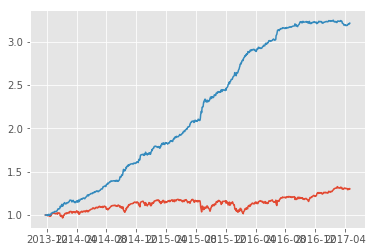

In [9]:
data_test = datanew.ix[save_test_index]
asset = np.zeros(len(data_test))
fee=5
nstock=100 # number of stocks to trade
price = data_test.ix[0]['Open'] * nstock
asset[0] = price
for i in range(len(data_test)):
    if best_pred[i][0] < best_pred[i][1]:
        #buy n stocks
        price += -data_test.ix[i]['Open'] * nstock + data_test.ix[i]['Close'] * nstock - fee
    else:
        #sell n stocks
        price += data_test.ix[i]['Open'] * nstock - data_test.ix[i]['Close'] * nstock - fee
    asset[i] = price
start_asset = data_test.ix[0]['Open'] * nstock # start asset: the total price of stocks bought in the beginning
ref = start_asset + data_test['Close'] * nstock - data_test.ix[0]['Open']*nstock # buy-hold reference
plt.plot(ref / start_asset)
plt.plot(pd.DataFrame(asset, index=data_test.index) / start_asset)

In [12]:
# return on investment (ROI)
asset[-1]/start_asset

3.2167278359690905